In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [3]:
latent_dim = 32

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    200,768 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 32)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 223,744 (874.00 KB)

 Trainable params: 223,744 (874.00 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(64, activation="relu")(latent_inputs)

x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3136)           │       103,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,169 (621.75 KB)

 Trainable params: 159,169 (621.75 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")              # raw KL
        self.kl_weighted_tracker = keras.metrics.Mean(name="kl_loss_weighted")  # beta*KL

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.kl_weighted_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def train_step(self, data):
        noisy_images , clean_images = data

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(noisy_images)
            reconstruction = self.decoder(z)

            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(clean_images, reconstruction),
                    axis=(1, 2),
                )
            )

            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))  # raw KL

            total_loss = reconstruction_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.kl_weighted_tracker.update_state(self.beta * kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "kl_loss_weighted": self.kl_weighted_tracker.result(),
            "beta": self.beta,
        }

In [6]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.expand_dims(x_train, -1).astype("float32") / 255

noise_levels = [0.0, 0.1, 0.2, 0.5]
SEED = 1337
rng = np.random.default_rng(SEED)

noisy_list = []
clean_list = []

for s in noise_levels:
    noise = rng.normal(loc=0.0, scale=1.0, size=mnist_digits.shape).astype("float32")
    mnist_noisy_s = np.clip(mnist_digits + s * noise, 0.0, 1.0)

    noisy_list.append(mnist_noisy_s)
    clean_list.append(mnist_digits)   # repeat clean targets

mnist_digits_noisy = np.concatenate(noisy_list, axis=0)   # (240000, 28, 28, 1)
mnist_digits_clean = np.concatenate(clean_list, axis=0)   # (240000, 28, 28, 1)

# shuffle together
perm = rng.permutation(mnist_digits_noisy.shape[0])
mnist_digits_noisy = mnist_digits_noisy[perm]
mnist_digits_clean = mnist_digits_clean[perm]



beta = 0
vae = VAE(encoder, decoder, beta)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits_noisy, mnist_digits_clean, epochs=160, batch_size=128)

Epoch 1/160
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - beta: 0.0000e+00 - kl_loss: 241.1252 - kl_loss_weighted: 0.0000e+00 - loss: 154.7854 - reconstruction_loss: 154.7854
Epoch 2/160
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - beta: 0.0000e+00 - kl_loss: 256.8334 - kl_loss_weighted: 0.0000e+00 - loss: 74.3984 - reconstruction_loss: 74.3984
Epoch 3/160
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - beta: 0.0000e+00 - kl_loss: 278.0027 - kl_loss_weighted: 0.0000e+00 - loss: 70.2583 - reconstruction_loss: 70.2583
Epoch 4/160
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - beta: 0.0000e+00 - kl_loss: 292.7066 - kl_loss_weighted: 0.0000e+00 - loss: 68.3307 - reconstruction_loss: 68.3307
Epoch 5/160
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - beta: 0.0000e+00 - kl_loss: 310.2640 - kl_loss_weighted: 0.0000e+00 - loss: 67.4076 - reconstruction_loss: 67.4076
Epoch 6/160
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - beta: 0.0000e+00 - kl_loss: 321.0107 - kl_loss_weighted: 0.0000e+00 - loss: 66.7

In [7]:
# Build inference-only model (no training logic)
noisy_inp = keras.Input(shape=(28, 28, 1), name="noisy_input")
z_mean, z_log_var, z = encoder(noisy_inp)
out = decoder(z)
denoiser = keras.Model(noisy_inp, out, name="denoiser")

# Save it
denoiser.save("denoiser.keras")


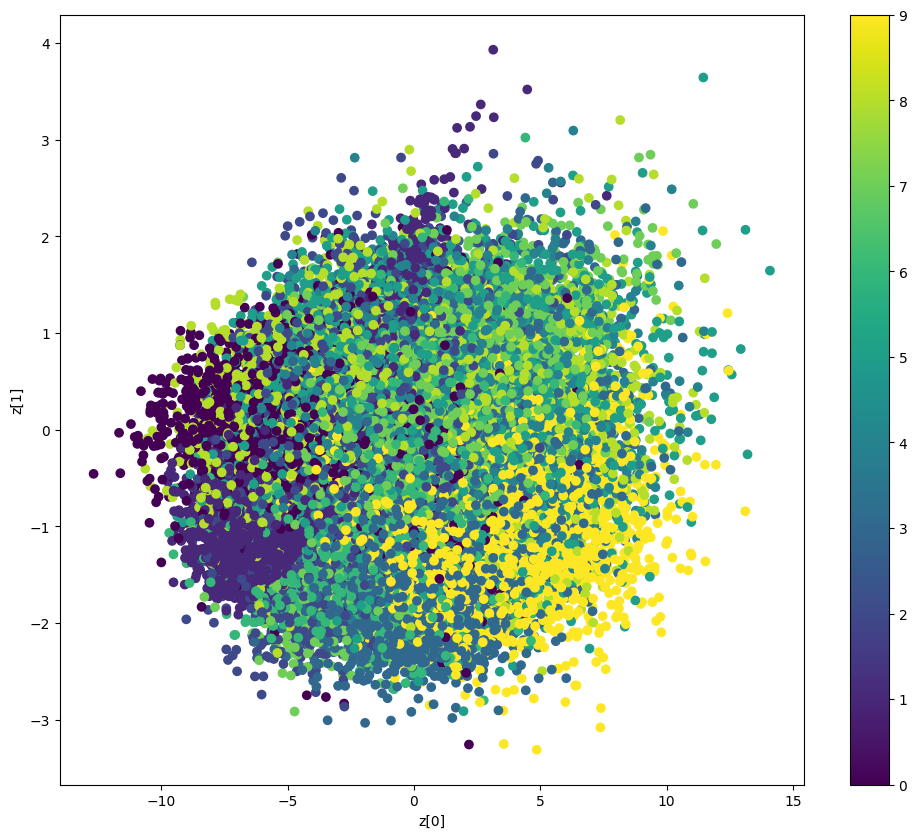

In [8]:
import matplotlib.pyplot as plt

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

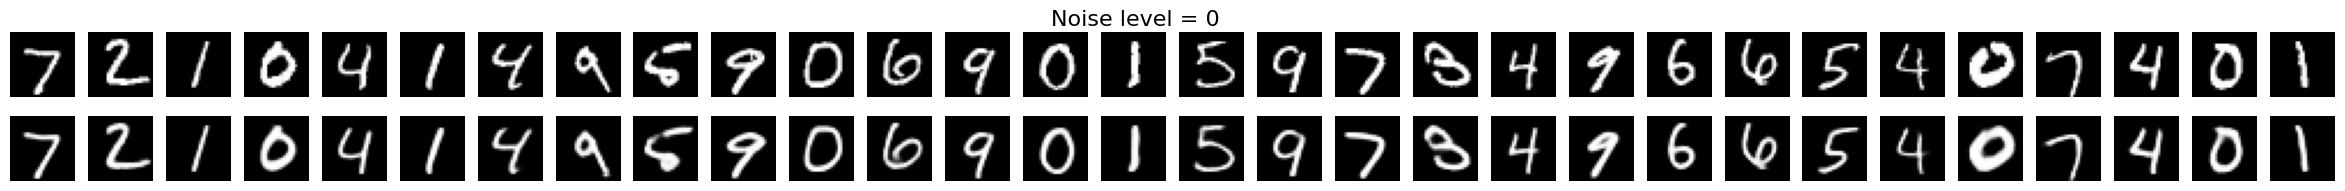

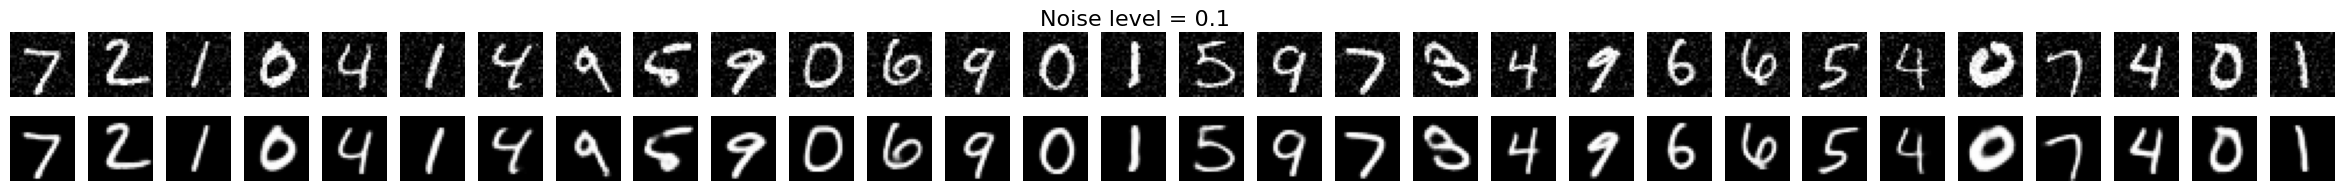

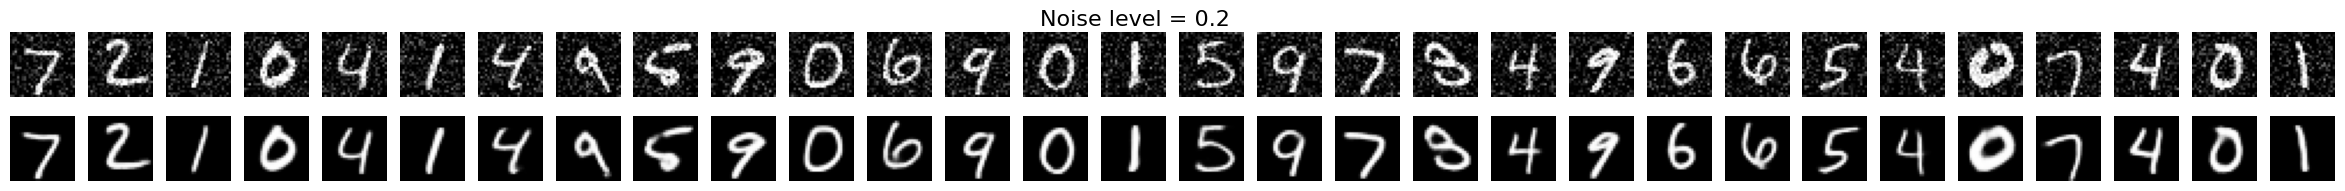

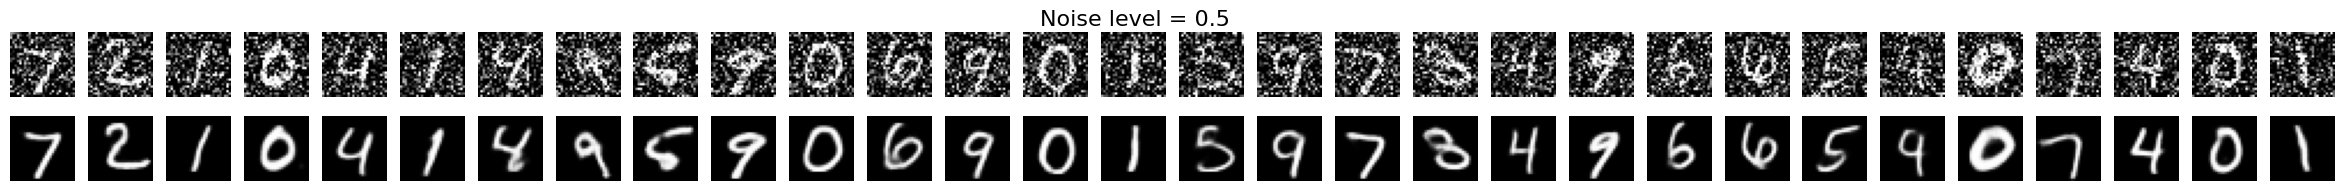

In [9]:
mnist_test = np.expand_dims(x_test, -1).astype("float32") / 255

noise_levels = [0, 0.1, 0.2, 0.5]

for n in noise_levels:

    # Add Gaussian noise

    mnist_noisy = mnist_test + n * np.random.normal(
        loc=0.0, scale=1.0, size=mnist_test.shape
    )
    mnist_noisy = np.clip(mnist_noisy, 0., 1.)

    # take the first 20 images
    num_samples = 30
    imgs = mnist_noisy[:num_samples]

    # predict only on these 20
    preds = vae.predict(imgs, verbose=0)

    plt.figure(figsize=(num_samples, 2))
    plt.suptitle(f"Noise level = {n}", fontsize=16)

    for i in range(num_samples):
        # noisy input
        plt.subplot(2, num_samples, i+1)
        plt.imshow(imgs[i].squeeze(), cmap="gray")
        plt.axis("off")

        # reconstruction
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(preds[i].squeeze(), cmap="gray")
        plt.axis("off")

    plt.show()


Evaluating on 1000 test images...
--------------------------------------------------
Noise Level     | Avg PSNR (dB)   | Avg SSIM       
--------------------------------------------------
0               | 23.7826         | 0.9395         
0.1             | 23.5862         | 0.9371         
0.2             | 22.9804         | 0.9283         
0.5             | 19.5439         | 0.8388         


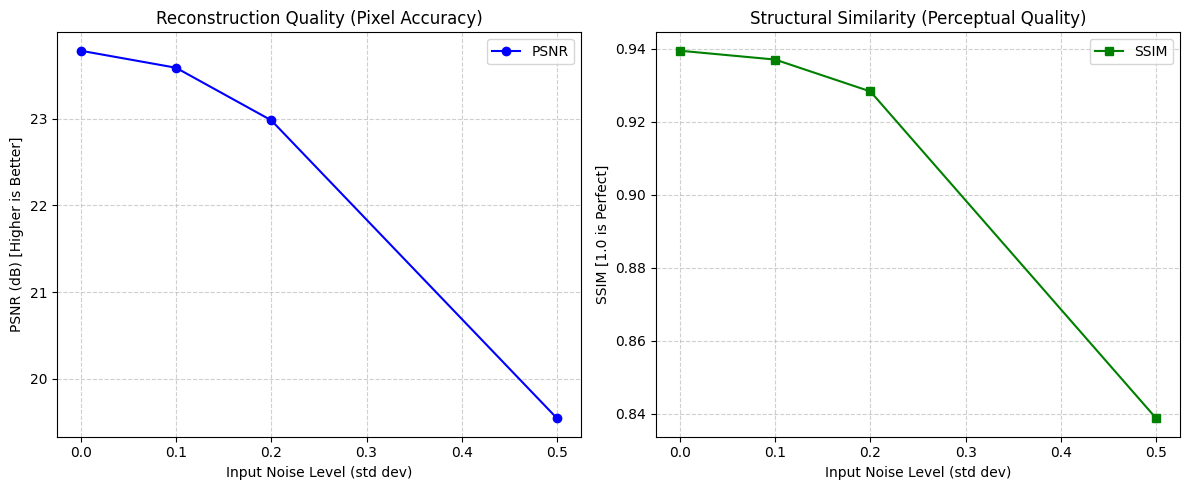

In [10]:
import matplotlib.pyplot as plt

# 1. Define the metrics container
results = {
    "noise_levels": [],
    "psnr": [],
    "ssim": []
}

# 2. Select a subset for evaluation (Evaluating all 10k can be slow for SSIM)
n_eval = 1000
x_test_eval = mnist_test[:n_eval]

print(f"Evaluating on {n_eval} test images...")
print("-" * 50)
print(f"{'Noise Level':<15} | {'Avg PSNR (dB)':<15} | {'Avg SSIM':<15}")
print("-" * 50)

noise_levels = [0, 0.1, 0.2, 0.5]

for n in noise_levels:
    # --- A. Generate Noisy Input ---
    # We use the same seed to ensure reproducibility
    np.random.seed(SEED)
    noise = np.random.normal(loc=0.0, scale=1.0, size=x_test_eval.shape)
    x_test_noisy = x_test_eval + n * noise
    x_test_noisy = np.clip(x_test_noisy, 0., 1.).astype("float32")

    # --- B. Get VAE Reconstruction ---
    # The model tries to reconstruct the *clean* image from the *noisy* input
    reconstructed = vae.predict(x_test_noisy, verbose=0)

    # --- C. Calculate Metrics (Vectorized with TensorFlow) ---
    # Compare: Clean Original (x_test_eval) vs Reconstructed

    # PSNR
    psnr_scores = tf.image.psnr(
        x_test_eval,
        reconstructed,
        max_val=1.0
    )
    avg_psnr = tf.reduce_mean(psnr_scores).numpy()

    # SSIM
    ssim_scores = tf.image.ssim(
        x_test_eval,
        reconstructed,
        max_val=1.0,
        filter_size=11,
        filter_sigma=1.5,
        k1=0.01,
        k2=0.03
    )
    avg_ssim = tf.reduce_mean(ssim_scores).numpy()

    # --- D. Store & Print ---
    results["noise_levels"].append(n)
    results["psnr"].append(avg_psnr)
    results["ssim"].append(avg_ssim)

    print(f"{n:<15} | {avg_psnr:<15.4f} | {avg_ssim:<15.4f}")

# 3. Plot the Degradation Curves
plt.figure(figsize=(12, 5))

# Plot PSNR
plt.subplot(1, 2, 1)
plt.plot(results["noise_levels"], results["psnr"], marker='o', color='blue', label='PSNR')
plt.title("Reconstruction Quality (Pixel Accuracy)")
plt.xlabel("Input Noise Level (std dev)")
plt.ylabel("PSNR (dB) [Higher is Better]")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Plot SSIM
plt.subplot(1, 2, 2)
plt.plot(results["noise_levels"], results["ssim"], marker='s', color='green', label='SSIM')
plt.title("Structural Similarity (Perceptual Quality)")
plt.xlabel("Input Noise Level (std dev)")
plt.ylabel("SSIM [1.0 is Perfect]")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()